In [1]:
import numpy as np
import pandas as pd
import time
import librosa
import librosa.display

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

from boris_util import *

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN

from sklearn.pipeline import Pipeline

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

# Exploring the Dataset

First thing's first, let's load the dataset. I created a new function that loads up the dataset for me and converts it into a pandas dataframe for easy access. For more information on this, please see the `Data Cleaning` notebook

In [3]:
dataset = read_and_combine_data('453_923_bundle_archive', read_noisy_data=False)
print(dataset.shape)
dataset.head()

processed 100.00%
(436, 4)


signal  sampling_rate  \
0  [2.2960085e-05, -0.00012982322, -0.00018070513...          22050   
1  [-1.0927635e-05, 1.0574424e-06, 2.108567e-06, ...          22050   
2  [3.728857e-05, -0.0001664555, -7.4023155e-05, ...          22050   
3  [-0.0027429417, -0.0066496185, -0.0049779303, ...          22050   
4  [0.000106223946, 0.0015002153, 0.0097254915, 0...          22050   

   audio_length     label  
0           9.0  artifact  
1           9.0  artifact  
2           9.0  artifact  
3           9.0  artifact  
4           9.0  artifact

Let's take a look at the class distribution to see if there is any concern of class imbalance

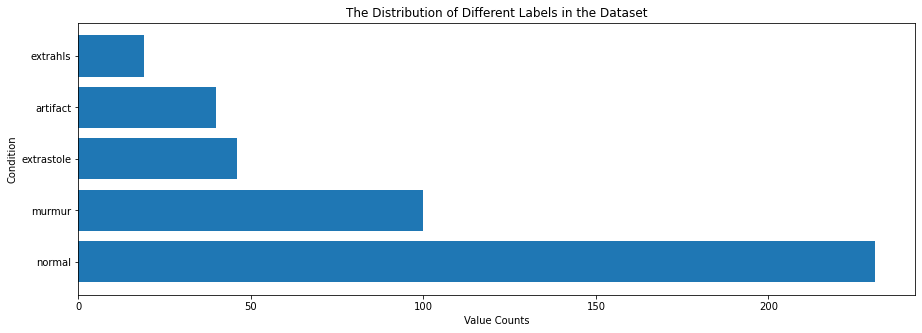

In [4]:
label_counts = dataset['label'].value_counts()

plt.figure(figsize=(15,5))
plt.barh(label_counts.index, label_counts.values)
plt.xlabel("Value Counts")
plt.ylabel("Condition")
plt.title("The Distribution of Different Labels in the Dataset")
plt.show()

There is certainly an issue of class imbalance here. A naive classifier could guess pretty well by simply guessing "Normal" on all the examples

## Combine all Abnormalities

Let's try a simple example first, we will combine all abnormalities into a single label "abnormal". We won't count artifacts in that category

In [5]:
def relabel(label):
    if (label == "normal"):
        return "normal"
    else:
        return "abnormal"
dataset['label'] = dataset['label'].apply(relabel)

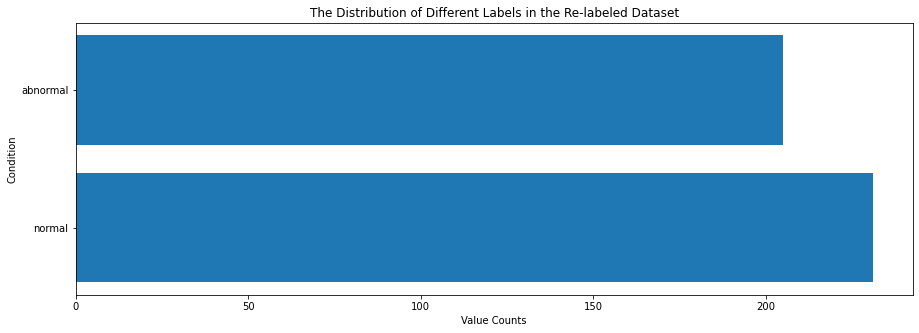

In [6]:
label_counts = dataset['label'].value_counts()

plt.figure(figsize=(15,5))
plt.barh(label_counts.index, label_counts.values)
plt.xlabel("Value Counts")
plt.ylabel("Condition")
plt.title("The Distribution of Different Labels in the Re-labeled Dataset")
plt.show()

Let's split our data now into a simple train/test stratified split

In [7]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, stratify=dataset['label'], random_state=1)
print(train_dataset.shape)
print(test_dataset.shape)

(305, 4)
(131, 4)


In [8]:
train_dataset.head()

signal  sampling_rate  \
302  [-0.014594975, -0.016623363, -0.017930867, -0....          22050   
401  [0.00535502, 0.0048318487, 0.0038144102, 0.002...          22050   
311  [-0.0009814408, -0.00052338943, 9.0988244e-05,...          22050   
346  [-0.007578952, -0.011004641, -0.015165693, -0....          22050   
410  [-0.030912954, -0.033952978, -0.035377894, -0....          22050   

     audio_length   label  
302      5.025533  normal  
401      1.724263  normal  
311      3.822766  normal  
346      4.312018  normal  
410      3.167755  normal

## Dataset Augmentation

We won't get very far with the examples we have. There aren't very many of them

Luckily, we can easily augment the dataset by shifting the data and/or adding some noise

In [9]:
DATASET_TARGET = train_dataset.shape[0]
#DATASET_TARGET = 2000
CV_FOLD = 10

In [10]:
# find the label ratios
inverse_counts = 1/train_dataset['label'].value_counts()
probability_counts = inverse_counts/inverse_counts.sum()
probability_counts

normal      0.468852
abnormal    0.531148
Name: label, dtype: float64

In [11]:
# https://medium.com/@makcedward/data-augmentation-for-audio-76912b01fdf6
    
def shift_sound(data, sampling_rate, shift_max, shift_direction='both'):
    shift = np.random.randint(int(shift_max * data.shape[0]))
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    # Set to silence for heading/ tailing
    if shift > 0:
        augmented_data = augmented_data[shift:]
    else:
        augmented_data = augmented_data[:shift]
    return augmented_data

In [12]:
def make_noise(data, noise_factor):
    
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    
    
    return augmented_data

In [13]:
choices = np.random.choice(probability_counts.index, 
                           p=probability_counts.values, 
                           size=(DATASET_TARGET,))
i = 0
while train_dataset.shape[0] < DATASET_TARGET:
    choice = choices[i]
    available_instances = train_dataset[train_dataset['label'] == choice]
    selected_row_position = np.random.randint(available_instances.shape[0])
    
    selected_row = available_instances.iloc[selected_row_position]
    
    base_signal = selected_row['signal']
    sampling_rate = selected_row['sampling_rate']
    
    shift_direction = 'both'
    new_signal = shift_sound(base_signal, sampling_rate, (np.random.random()*0.3), shift_direction)
    
        
    if (new_signal.shape[0] > 0):
        
        inject_noise = np.random.random() > 0.5
    
        if (inject_noise):
            new_signal = make_noise(new_signal, 0.01)
    
        new_series = pd.Series({'signal' :new_signal, 'sampling_rate': sampling_rate, 'label': choice})
        train_dataset = train_dataset.append(new_series, ignore_index=True)
    
        print(train_dataset.shape, end="\r")
    i+= 1

Now let's define a class which will convert the signals into Mel spectrograms

In [14]:
class MelEncoder:
    
    '''
        This transformer takes an audio signal and employes librosa
        to transform the audio signal into a Mel-frequency spectrogram.
        
        The transformation transforms the audio signal from samples in a 
        time domain, to frequencies over each time window. The frequencies
        are then collected into buckets which are easily distinguished by
        human hearing
    '''
    
    def __init__(self, flatten=True, n_fft=2048, hop_length=512, n_mels=128, sampling_rate=22050.0, n_windows=1000, verbose=0):
        
        
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.sampling_rate = sampling_rate
        self.n_windows = n_windows
        self.verbose = verbose
        
        
        self.flatten = flatten
        
    
    def fit(self, X, y=None):
        '''
            This method doesn't do much except initialize
        '''
        self.longest_signal_length = None
        
    
    
    def _create_spectrogram_list(self, X):
        
        spectrogram_list = []
        
        
        for i, signal in enumerate(X):
                mel_spectrogram = self._signal_to_mel_spectrogram(signal)
                spectrogram_list.append(mel_spectrogram)
                if (self.verbose):
                    print(f"processed: {round(100*i/X.shape[0], 2)}%", end="\r")
                    
                
        print(f"processed: {round(100*i/X.shape[0], 2)}%")
        
        return spectrogram_list
    
    
    def _find_longest_signal_length(self, spectrogram_list):
        
        max_length = 0
        for mel_spectrogram in spectrogram_list:
            if (mel_spectrogram.shape[1] > max_length):
                max_length = mel_spectrogram.shape[1]

        return max_length
            
    def _build_mel_spectrogram_stack(self, spectrogram_list):
        
        X_transformed = np.zeros((len(spectrogram_list), self.n_mels, self.longest_signal_length))
        
        for i, mel_spectrogram in enumerate(spectrogram_list):
            if (mel_spectrogram.shape[1] <= self.longest_signal_length):
                X_transformed[i, :, -mel_spectrogram.shape[1]:] = mel_spectrogram[:, :]
            else:
                X_transformed[i, :, :] = mel_spectrogram[:, -self.longest_signal_length:]
                
        return X_transformed
    
    
    def transform(self, X):
        
        spectrogram_list = self._create_spectrogram_list(X)
        
        if (self.longest_signal_length is None):
            self.longest_signal_length = self._find_longest_signal_length(spectrogram_list)
            
        X_transformed = self._build_mel_spectrogram_stack(spectrogram_list)
        
        
        if (self.flatten):
            return X_transformed.reshape(X_transformed.shape[0], -1)
        else:
            return X_transformed
        
        
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)
        
        
        
        
    # https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
    def _longest_signal(self, signals):
        max_length = 0
        for signal in signals:
            if (len(signal) > max_length):
                max_length = len(signal)

        return max_length
    
    
    def _signal_to_mel_spectrogram(self, signal):
        
        
        if (self.n_windows is not None):
            hop_length = signal.shape[0]//self.n_windows
        else:
            hop_length = self.hop_length
        S = librosa.feature.melspectrogram(signal, 
                                           sr=self.sampling_rate, 
                                           n_fft=self.n_fft, 
                                           hop_length=hop_length, 
                                           n_mels=self.n_mels)
        S_DB = librosa.power_to_db(S, ref=np.max)
        return S_DB

In [15]:
my_encoder = MelEncoder(n_mels=128, n_windows=1000, verbose=1)

In [16]:
my_encoder.fit(train_dataset['signal'])

In [17]:
X_train_mel = my_encoder.transform(train_dataset['signal'])

processed: 99.67%


In [18]:
X_train_mel.shape

(305, 134400)

In [19]:
X_test_mel = my_encoder.transform(test_dataset['signal'])

processed: 99.24%


In [20]:
X_test_mel.shape

(131, 134400)

## PCA

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
%%time 
my_mmscaler = MinMaxScaler()

X_train_mel = my_mmscaler.fit_transform(X_train_mel)
X_test_mel = my_mmscaler.transform(X_test_mel)

CPU times: user 454 ms, sys: 169 ms, total: 623 ms
Wall time: 622 ms


In [23]:
X_train_mel = X_train_mel
X_train_mel.shape

(305, 134400)

In [24]:
%%time 

component_number = min(*X_train_mel.shape)
my_pca = PCA(n_components=component_number, svd_solver='auto')
my_pca.fit(X_train_mel)

CPU times: user 1min 47s, sys: 5.58 s, total: 1min 52s
Wall time: 14.5 s


PCA(n_components=305)

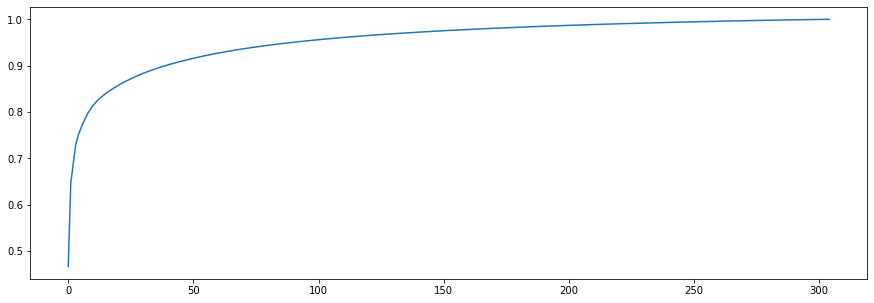

In [25]:
plt.figure(figsize=(15,5))
plt.plot(my_pca.explained_variance_ratio_.cumsum())
plt.show()

In [26]:
X_train_mel = my_pca.transform(X_train_mel)
X_test_mel = my_pca.transform(X_test_mel)

In [27]:
X_train_mel.shape

(305, 305)

In [28]:
X_test_mel.shape

(131, 305)

## Basic Model - Logistic Regression

Let's start by establishing a baseline performance. I am just going to load the raw audio data as features (where each feature is an audio measurement) and see how well a simple logistic regression (linear model) and decision tree (non-linear model) will perform

In [29]:
condition_label_encoder = LabelEncoder()


y_train = condition_label_encoder.fit_transform(train_dataset['label'])[:X_train_mel.shape[0]]
y_test = condition_label_encoder.transform(test_dataset['label'])

print(X_train_mel.shape, X_test_mel.shape)
print(y_train.shape, y_test.shape)

(305, 305) (131, 305)
(305,) (131,)


In [30]:
%%time

my_logit = LogisticRegression(random_state=1).fit(X_train_mel, y_train)
train_acc = my_logit.score(X_train_mel, y_train)
test_acc = my_logit.score(X_test_mel, y_test)

CPU times: user 410 ms, sys: 40.6 ms, total: 451 ms
Wall time: 50.5 ms


In [31]:
y_proba_train = my_logit.predict_proba(X_train_mel)[:, 1]
y_proba_test = my_logit.predict_proba(X_test_mel)[:, 1]


train_auc = roc_auc_score(y_train, y_proba_train)
test_auc = roc_auc_score(y_test, y_proba_test)

In [32]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

The training accuracy is 100.0%
The test accuracy is 56.49%


In [33]:
print(f"The training AUC is {round(train_auc*100,2)}%")
print(f"The test AUC is {round(test_auc*100,2)}%")

The training AUC is 100.0%
The test AUC is 61.92%


In [34]:
y_proba = my_logit.predict_proba(X_test_mel)

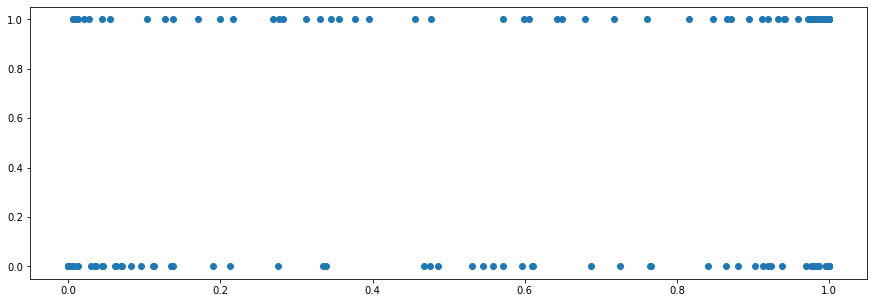

In [35]:
plt.figure(figsize=(15, 5))
plt.scatter(y_proba[:, 1], y_test)
plt.show();

In [36]:
def boris_score(y_true, y_positive_proba):
    
    positive_pure_points = 0
    negative_pure_points = 0
    for threshold in np.unique(y_positive_proba):
        
        under_threshold = y_true[y_positive_proba < threshold]
        if (np.sum(under_threshold) == 0):
            if (len(under_threshold) > negative_pure_points):
                negative_pure_points = len(under_threshold)
                
        over_threshold = y_true[y_positive_proba >= threshold]
        if (np.sum(over_threshold) == len(over_threshold)):
            if (len(over_threshold) > positive_pure_points):
                positive_pure_points = len(over_threshold)
                
    return positive_pure_points + negative_pure_points
        
        

In [37]:
from sklearn.metrics import make_scorer
score = make_scorer(boris_score, needs_proba=True)

In [38]:
score(my_logit, X_test_mel, y_test)

8

Extremely suspicious results. There is clearly a very large sign of overfitting here. Let's explore how the logistic regression makes decisions.

Let's plot the coefficients as if they were an audio mask (which is really what they end up becoming).

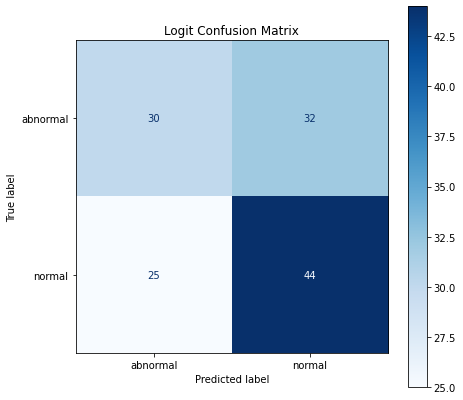

In [39]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_logit, X_test_mel, y_test,
                             display_labels = condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

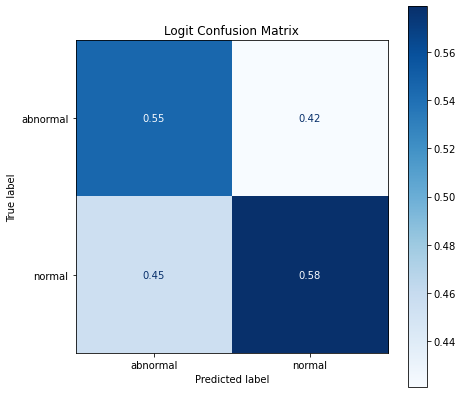

In [40]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_logit, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='pred',
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

In [41]:
param_grid = {'penalty': ['l1', 'l2'],
              'C': [2**i for i in range(-17, 18)]}
my_estimator = LogisticRegression(solver='saga')
my_logit_gs = GridSearchCV(my_estimator, param_grid, cv=CV_FOLD, verbose=1, n_jobs=3, scoring=score)

In [42]:
%%time
my_logit_gs.fit(X_train_mel, y_train);

Fitting 10 folds for each of 70 candidates, totalling 700 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 185 tasks      | elapsed:    3.8s
[Parallel(n_jobs=3)]: Done 491 tasks      | elapsed:   14.1s


CPU times: user 1.08 s, sys: 158 ms, total: 1.23 s
Wall time: 22.5 s


[Parallel(n_jobs=3)]: Done 700 out of 700 | elapsed:   22.3s finished


GridSearchCV(cv=10, estimator=LogisticRegression(solver='saga'), n_jobs=3,
             param_grid={'C': [7.62939453125e-06, 1.52587890625e-05,
                               3.0517578125e-05, 6.103515625e-05,
                               0.0001220703125, 0.000244140625, 0.00048828125,
                               0.0009765625, 0.001953125, 0.00390625, 0.0078125,
                               0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1,
                               2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
                               4096, ...],
                         'penalty': ['l1', 'l2']},
             scoring=make_scorer(boris_score, needs_proba=True), verbose=1)

In [43]:
my_logit_gs.best_params_

{'C': 0.00048828125, 'penalty': 'l2'}

In [44]:
train_acc = my_logit_gs.score(X_train_mel, y_train)
test_acc = my_logit_gs.score(X_test_mel, y_test)

In [45]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

The training accuracy is 4700%
The test accuracy is 1600%


In [46]:
y_proba_train = my_logit_gs.predict_proba(X_train_mel)[:, 1]
y_proba_test = my_logit_gs.predict_proba(X_test_mel)[:, 1]


train_auc = roc_auc_score(y_train, y_proba_train)
test_auc = roc_auc_score(y_test, y_proba_test)

In [47]:
print(f"The training AUC is {round(train_auc*100,2)}%")
print(f"The test AUC is {round(test_auc*100,2)}%")

The training AUC is 83.64%
The test AUC is 73.05%


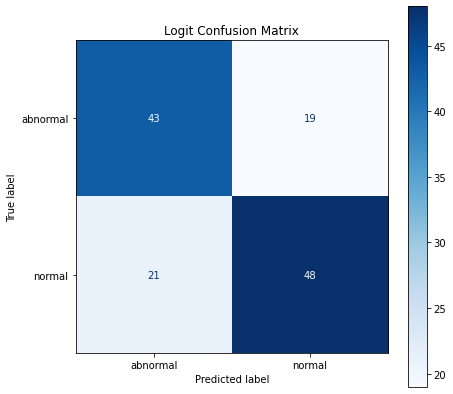

In [48]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_logit_gs, X_test_mel, y_test,
                             display_labels = condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

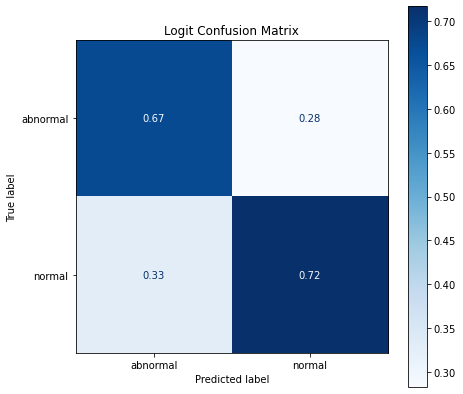

In [49]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_logit_gs, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='pred',
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

In [50]:
print(classification_report(y_test, my_logit_gs.predict(X_test_mel)))

              precision    recall  f1-score   support

           0       0.67      0.69      0.68        62
           1       0.72      0.70      0.71        69

    accuracy                           0.69       131
   macro avg       0.69      0.69      0.69       131
weighted avg       0.70      0.69      0.69       131



In [51]:
y_proba = my_logit_gs.predict_proba(X_test_mel)

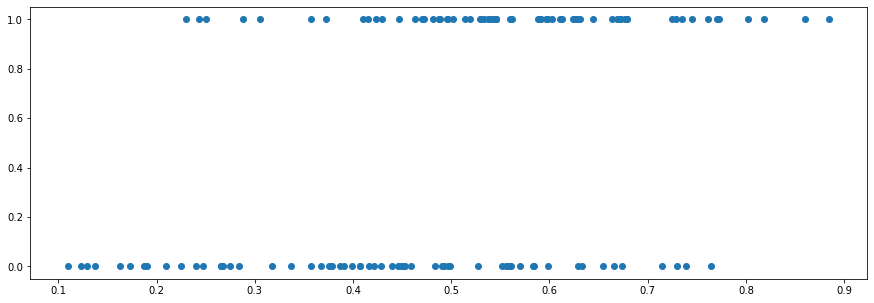

In [52]:
plt.figure(figsize=(15, 5))
plt.scatter(y_proba[:, 1], y_test)
plt.show();

### Let's look at the examples that were misclassified 

In [53]:
misclassified_examples = test_dataset.loc[y_test == my_logit_gs.predict(X_test_mel)]
misclassified_examples

signal  sampling_rate  \
426  [-0.029129596, -0.03262708, -0.034381352, -0.0...          22050   
328  [0.0013529711, 0.0024457676, 0.003745941, 0.00...          22050   
256  [0.10968155, 0.1198264, 0.124032594, 0.1228437...          22050   
247  [-0.0041752537, -0.0053787753, -0.0064964327, ...          22050   
64   [0.008199658, 0.0116692, 0.009676605, 0.010819...          22050   
..                                                 ...            ...   
374  [-0.021742398, -0.02307921, -0.023118906, -0.0...          22050   
363  [-0.010866927, -0.011477671, -0.011558568, -0....          22050   
86   [-0.00061363465, -0.00093659124, -0.0008520273...          22050   
71   [0.01639377, 0.026940092, 0.02657546, 0.029489...          22050   
180  [0.030754091, 0.03522011, 0.038546264, 0.04074...          22050   

     audio_length     label  
426      2.581270    normal  
328      2.217778    normal  
256      5.156508    normal  
247      3.761542    normal  
64       9.000000  abnormal  
..            ...       ...  
374      1.233288    normal  
363      2.369751    normal  
86       7.935556  abnormal  
71       7.935556  abnormal  
180     16.960272  abnormal  

[91 rows x 4 columns]

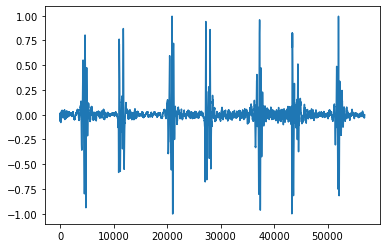

In [54]:
plt.plot(misclassified_examples.loc[426, 'signal'])

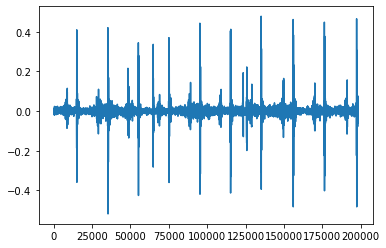

In [55]:
plt.plot(misclassified_examples.loc[64, 'signal'])

## Basic Model - Support Vector Machine

Let's start by establishing a baseline performance. I am just going to load the raw audio data as features (where each feature is an audio measurement) and see how well a simple logistic regression (linear model) and decision tree (non-linear model) will perform

In [56]:
condition_label_encoder = LabelEncoder()


y_train = condition_label_encoder.fit_transform(train_dataset['label'])[:X_train_mel.shape[0]]
y_test = condition_label_encoder.transform(test_dataset['label'])

print(X_train_mel.shape, X_test_mel.shape)
print(y_train.shape, y_test.shape)

(305, 305) (131, 305)
(305,) (131,)


In [57]:
%%time

my_svm = SVC(random_state=1, max_iter=1000, probability=True).fit(X_train_mel, y_train)
train_acc = my_svm.score(X_train_mel, y_train)
test_acc = my_svm.score(X_test_mel, y_test)

CPU times: user 205 ms, sys: 1.98 ms, total: 207 ms
Wall time: 206 ms


In [58]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

The training accuracy is 78.69%
The test accuracy is 71.76%


In [69]:
param_grid = {'C': [10**i for i in range(-7, 8)],
              'kernel': ['poly', 'rbf', 'sigmoid', 'linear']}
my_estimator = SVC(max_iter=1000, probability=True)
my_svm_gs = GridSearchCV(my_estimator, param_grid, cv=CV_FOLD, verbose=1, n_jobs=3, scoring=score)

In [70]:
%%time
my_svm_gs.fit(X_train_mel, y_train);

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  82 tasks      | elapsed:    3.7s
[Parallel(n_jobs=3)]: Done 382 tasks      | elapsed:   15.9s


CPU times: user 779 ms, sys: 67.2 ms, total: 847 ms
Wall time: 23.8 s


[Parallel(n_jobs=3)]: Done 600 out of 600 | elapsed:   23.6s finished


GridSearchCV(cv=10, estimator=SVC(max_iter=1000, probability=True), n_jobs=3,
             param_grid={'C': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                               10, 100, 1000, 10000, 100000, 1000000,
                               10000000],
                         'kernel': ['poly', 'rbf', 'sigmoid', 'linear']},
             scoring=make_scorer(boris_score, needs_proba=True), verbose=1)

In [71]:
my_svm_gs.best_params_

{'C': 100, 'kernel': 'rbf'}

In [72]:
train_acc = my_svm_gs.score(X_train_mel, y_train)
test_acc = my_svm_gs.score(X_test_mel, y_test)

In [73]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

The training accuracy is 30500%
The test accuracy is 2100%


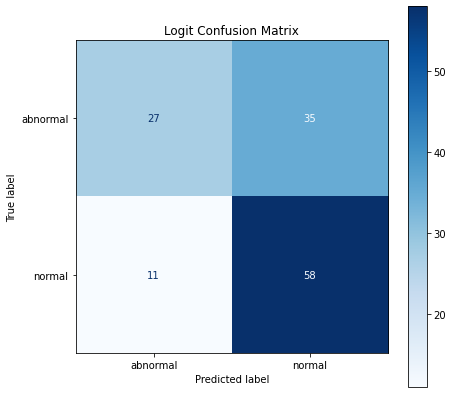

In [74]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_svm_gs, X_test_mel, y_test,
                             display_labels = condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

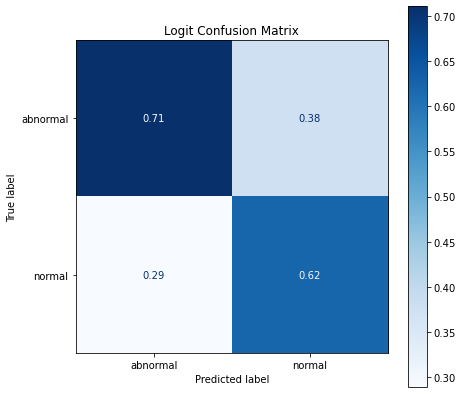

In [75]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_svm_gs, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='pred',
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

In [76]:
print(classification_report(y_test, my_svm_gs.predict(X_test_mel)))

              precision    recall  f1-score   support

           0       0.71      0.44      0.54        62
           1       0.62      0.84      0.72        69

    accuracy                           0.65       131
   macro avg       0.67      0.64      0.63       131
weighted avg       0.66      0.65      0.63       131



In [77]:
y_proba = my_svm_gs.predict_proba(X_test_mel)

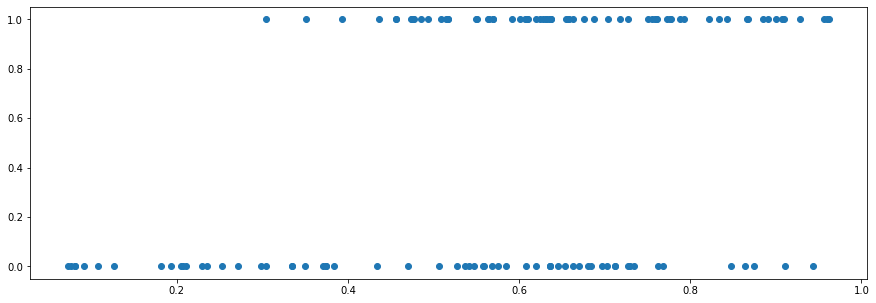

In [78]:
plt.figure(figsize=(15, 5))
plt.scatter(y_proba[:, 1], y_test)
plt.show();

## Basic Model - KNN

Let's start by establishing a baseline performance. I am just going to load the raw audio data as features (where each feature is an audio measurement) and see how well a simple logistic regression (linear model) and decision tree (non-linear model) will perform

In [79]:
condition_label_encoder = LabelEncoder()


y_train = condition_label_encoder.fit_transform(train_dataset['label'])[:X_train_mel.shape[0]]
y_test = condition_label_encoder.transform(test_dataset['label'])

print(X_train_mel.shape, X_test_mel.shape)
print(y_train.shape, y_test.shape)

(305, 305) (131, 305)
(305,) (131,)


In [80]:
%%time

my_knn = KNN().fit(X_train_mel, y_train)
train_acc = my_knn.score(X_train_mel, y_train)
test_acc = my_knn.score(X_test_mel, y_test)

CPU times: user 70.5 ms, sys: 1.6 ms, total: 72.1 ms
Wall time: 70.8 ms


In [81]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

The training accuracy is 73.44%
The test accuracy is 64.89%


Extremely suspicious results. There is clearly a very large sign of overfitting here. Let's explore how the logistic regression makes decisions.

Let's plot the coefficients as if they were an audio mask (which is really what they end up becoming).

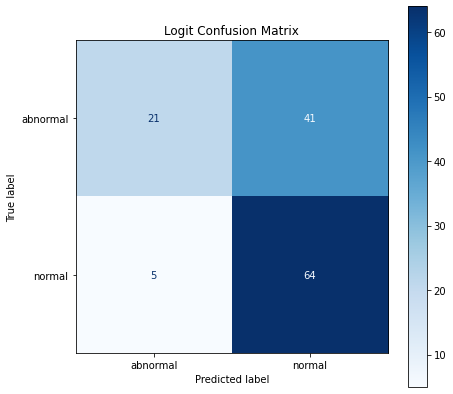

In [82]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_knn, X_test_mel, y_test,
                             display_labels = condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

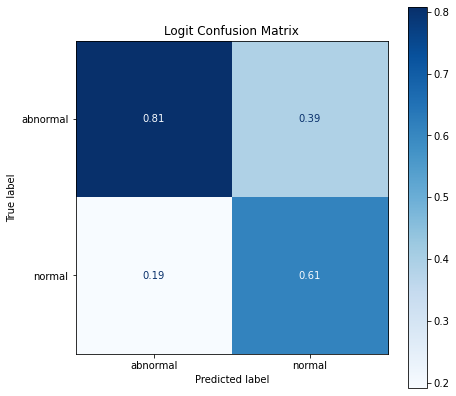

In [83]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_knn, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='pred',
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

In [84]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [85]:
param_grid = {'n_neighbors': [i for i in range(3,10)] + \
                             [i for i in range(10, 100, 5)] + \
                             [i for i in range(100, X_train_mel.shape[0]//2, 20)],
              'weights': ['uniform', 'distance']}

my_pipe = Pipeline([('scaler', MinMaxScaler()),
                    ('knn', KNN(algorithm='auto'))])

my_knn_gs = GridSearchCV(KNN(algorithm='auto'), param_grid, cv=CV_FOLD, verbose=1, n_jobs=3, scoring=score)

In [86]:
%%time
my_knn_gs.fit(X_train_mel, y_train);

Fitting 10 folds for each of 56 candidates, totalling 560 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 484 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done 560 out of 560 | elapsed:    1.4s finished


CPU times: user 233 ms, sys: 22.2 ms, total: 255 ms
Wall time: 1.44 s


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=3,
             param_grid={'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25,
                                         30, 35, 40, 45, 50, 55, 60, 65, 70, 75,
                                         80, 85, 90, 95, 100, 120, 140],
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(boris_score, needs_proba=True), verbose=1)

In [87]:
my_knn_gs.best_params_

{'n_neighbors': 15, 'weights': 'distance'}

In [88]:
train_acc = my_knn_gs.score(X_train_mel, y_train)
test_acc = my_knn_gs.score(X_test_mel, y_test)

In [89]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

The training accuracy is 30500%
The test accuracy is 1300%


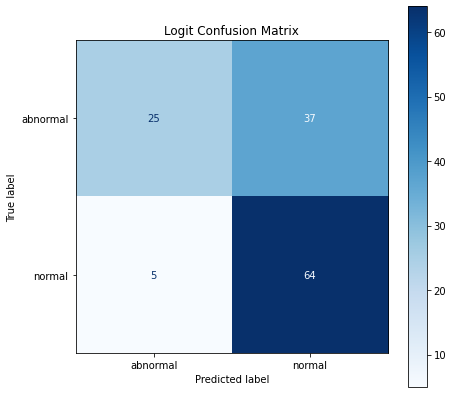

In [90]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_knn_gs, X_test_mel, y_test,
                             display_labels = condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

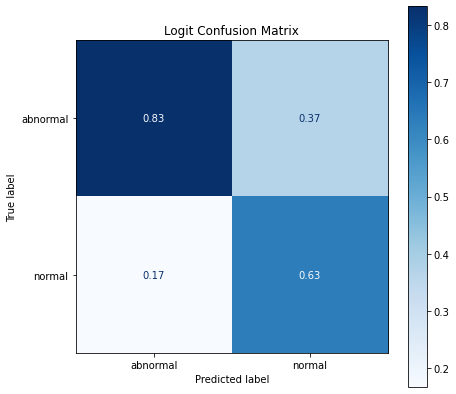

In [91]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_knn_gs, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='pred',
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

In [92]:
print(classification_report(y_test, my_knn_gs.predict(X_test_mel)))

              precision    recall  f1-score   support

           0       0.83      0.40      0.54        62
           1       0.63      0.93      0.75        69

    accuracy                           0.68       131
   macro avg       0.73      0.67      0.65       131
weighted avg       0.73      0.68      0.65       131



In [93]:
y_proba = my_knn_gs.predict_proba(X_test_mel)

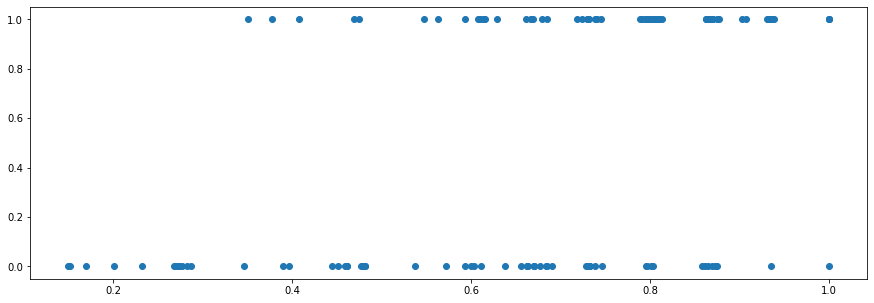

In [94]:
plt.figure(figsize=(15, 5))
plt.scatter(y_proba[:, 1], y_test)
plt.show();

## Basic Model - Decision Tree

As another baseline, I will train a decision tree to see if introducing non-linearity to the learning process produces better results

In [95]:
print(X_train_mel.shape, X_test_mel.shape)
print(y_train.shape, y_test.shape)

(305, 305) (131, 305)
(305,) (131,)


In [96]:
%%time 

# Let's set some regularization otherwise we know the tree will overfit
my_tree = DecisionTreeClassifier()
param_grid = {'min_samples_leaf': [i for i in range(1, 20)],
              'max_depth' : [i for i in range(1, X_train_mel.shape[1], X_train_mel.shape[1]//10)]+[None],
              'max_features': [i/10 for i in range(2, 11, 2)]}

my_tree_gs = GridSearchCV(my_tree, param_grid, cv=CV_FOLD, verbose=1, n_jobs=3, scoring=score)
my_tree_gs.fit(X_train_mel, y_train)


train_acc = my_tree_gs.score(X_train_mel, y_train)
test_acc = my_tree_gs.score(X_test_mel, y_test)

Fitting 10 folds for each of 1140 candidates, totalling 11400 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 185 tasks      | elapsed:    1.6s
[Parallel(n_jobs=3)]: Done 3511 tasks      | elapsed:   18.8s
[Parallel(n_jobs=3)]: Done 8511 tasks      | elapsed:   54.1s


CPU times: user 3.39 s, sys: 344 ms, total: 3.73 s
Wall time: 1min 13s


[Parallel(n_jobs=3)]: Done 11400 out of 11400 | elapsed:  1.2min finished


In [97]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

The training accuracy is 0%
The test accuracy is 0%


In [98]:
my_tree_gs.best_params_

{'max_depth': 241, 'max_features': 0.2, 'min_samples_leaf': 19}

Much better results! However, let's see how the model performs using the confusion matrix of the test set



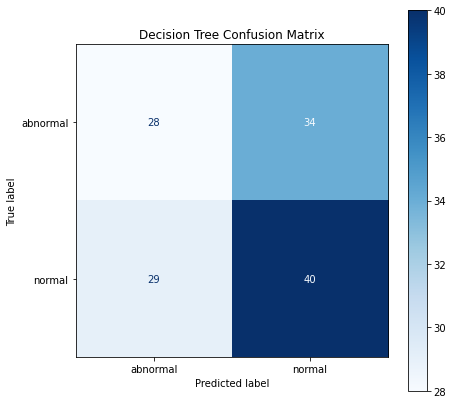

In [99]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_tree_gs, X_test_mel, y_test,
                             display_labels = condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title("Decision Tree Confusion Matrix")
plt.show()

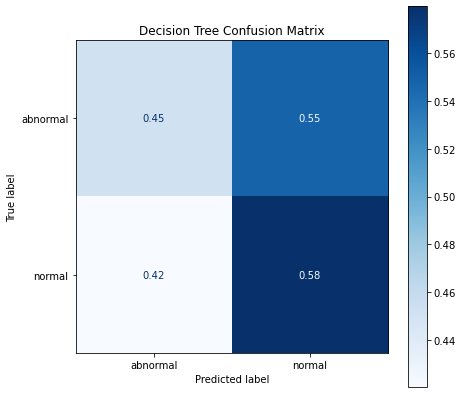

In [100]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_tree_gs, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='true',
                             ax=ax)
disp.ax_.set_title("Decision Tree Confusion Matrix")
plt.show()

As suspected, quite a bit of the classification seems to classify abnormal conditions and sounds as "normal" due to the sheer volume of that class, but interestingly, ~39% of the normal examples get misclassified as abnormalities.

In [101]:
print(classification_report(y_test, my_tree_gs.predict(X_test_mel)))

              precision    recall  f1-score   support

           0       0.49      0.45      0.47        62
           1       0.54      0.58      0.56        69

    accuracy                           0.52       131
   macro avg       0.52      0.52      0.52       131
weighted avg       0.52      0.52      0.52       131



In [102]:
y_proba = my_tree_gs.predict_proba(X_test_mel)

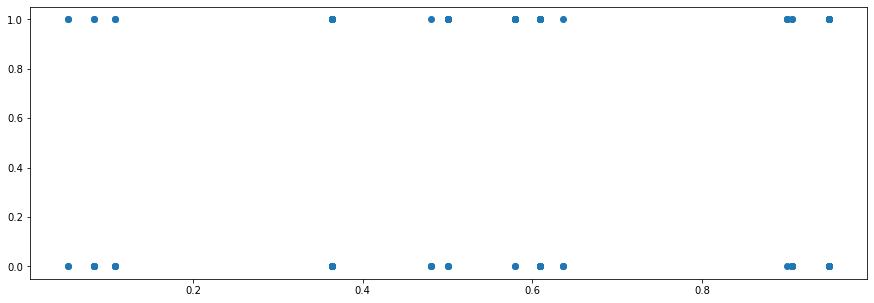

In [103]:
plt.figure(figsize=(15, 5))
plt.scatter(y_proba[:, 1], 
            y_test)
plt.show();

## Advanced Model - Random Forest

...

In [104]:
print(X_train_mel.shape, X_test_mel.shape)
print(y_train.shape, y_test.shape)

(305, 305) (131, 305)
(305,) (131,)


In [106]:
%%time 

param_grid = {'min_samples_leaf': [i for i in range(1, 20)],
              'max_depth' : [i for i in range(1, X_train_mel.shape[1], X_train_mel.shape[1]//10)]+[None],
              'max_features': [i/10 for i in range(2, 11, 2)],
              'n_estimators': [i*10 for i in range(1,10, 5)]}

my_rf_gs = GridSearchCV(RandomForestClassifier(random_state=1), 
                          param_grid, cv=CV_FOLD, verbose=1, n_jobs=3, scoring=score)
my_rf_gs.fit(X_train_mel, y_train)


train_acc = my_rf_gs.score(X_train_mel, y_train)
test_acc = my_rf_gs.score(X_test_mel, y_test)

Fitting 10 folds for each of 2280 candidates, totalling 22800 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed:    8.2s
[Parallel(n_jobs=3)]: Done 355 tasks      | elapsed:   15.2s
[Parallel(n_jobs=3)]: Done 855 tasks      | elapsed:   31.6s
[Parallel(n_jobs=3)]: Done 1555 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 2455 tasks      | elapsed:  2.1min
[Parallel(n_jobs=3)]: Done 3132 tasks      | elapsed:  3.4min
[Parallel(n_jobs=3)]: Done 3782 tasks      | elapsed:  5.2min
[Parallel(n_jobs=3)]: Done 4910 tasks      | elapsed:  6.9min
[Parallel(n_jobs=3)]: Done 5766 tasks      | elapsed:  9.2min
[Parallel(n_jobs=3)]: Done 7085 tasks      | elapsed: 11.4min
[Parallel(n_jobs=3)]: Done 8510 tasks      | elapsed: 14.1min
[Parallel(n_jobs=3)]: Done 9744 tasks      | elapsed: 16.9min
[Parallel(n_jobs=3)]: Done 11273 tasks      | elapsed: 20.2min
[Parallel(n_jobs=3)]: Done 12959 tasks      | elapsed: 23.5min
[Parallel(n_jobs=3)]: Done 14727 tasks      | elapsed: 27.

CPU times: user 36.7 s, sys: 4.16 s, total: 40.8 s
Wall time: 46min 19s


In [115]:
my_rf_gs.best_params_

{'max_depth': 31,
 'max_features': 0.2,
 'min_samples_leaf': 3,
 'n_estimators': 60}

In [107]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

The training accuracy is 30500%
The test accuracy is 800%


Much better results! However, let's see how the model performs using the confusion matrix of the test set



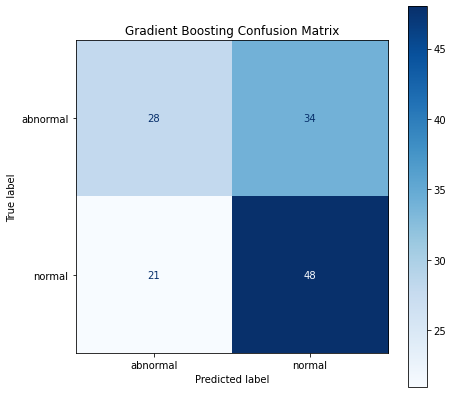

In [109]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_rf_gs, X_test_mel, y_test,
                             display_labels = condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title("Gradient Boosting Confusion Matrix")
plt.show()

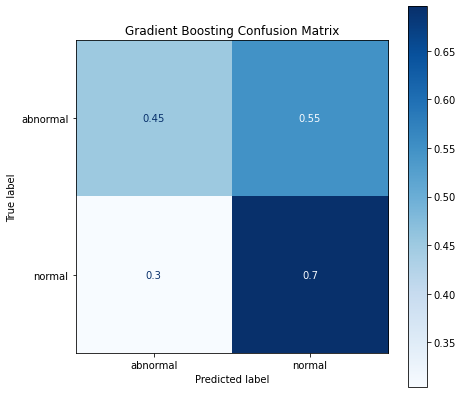

In [110]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_rf_gs, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='true',
                             ax=ax)
disp.ax_.set_title("Gradient Boosting Confusion Matrix")
plt.show()

In [111]:
print(classification_report(y_test, my_rf_gs.predict(X_test_mel)))

              precision    recall  f1-score   support

           0       0.57      0.45      0.50        62
           1       0.59      0.70      0.64        69

    accuracy                           0.58       131
   macro avg       0.58      0.57      0.57       131
weighted avg       0.58      0.58      0.57       131



In [113]:
y_proba = my_rf_gs.predict_proba(X_test_mel)

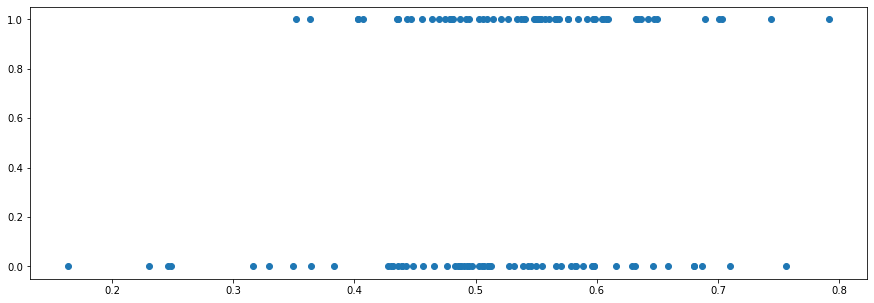

In [114]:
plt.figure(figsize=(15, 5))
plt.scatter(y_proba[:, 1], 
            y_test)
plt.show();

## Advanced Model - Gradient Boosting

...

In [116]:
print(X_train_mel.shape, X_test_mel.shape)
print(y_train.shape, y_test.shape)

(305, 305) (131, 305)
(305,) (131,)


In [ ]:
{'max_depth': 31,
 'max_features': 0.2,
 'min_samples_leaf': 3,
 'n_estimators': 60}

In [124]:
%%time 

# Let's set some regularization otherwise we know the tree will overfit
my_gb = GradientBoostingClassifier(min_samples_leaf=3, 
                                   max_features=0.8,
                                   max_depth=31,
                                   random_state=1, 
                                   n_estimators=60,
                                   verbose=1,
                                   learning_rate=0.1).fit(X_train_mel, y_train)


train_acc = my_gb.score(X_train_mel, y_train)
test_acc = my_gb.score(X_test_mel, y_test)

      Iter       Train Loss   Remaining Time 
         1           1.2147            2.27s
         2           1.0760            2.57s
         3           0.9548            2.59s
         4           0.8515            2.52s
         5           0.7593            2.51s
         6           0.6818            2.47s
         7           0.6107            2.40s
         8           0.5500            2.30s
         9           0.4954            2.22s
        10           0.4457            2.18s
        20           0.1704            1.68s
        30           0.0680            1.20s
        40           0.0275            0.78s
        50           0.0111            0.38s
        60           0.0046            0.00s
CPU times: user 2.3 s, sys: 8.52 ms, total: 2.31 s
Wall time: 2.31 s


In [125]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

The training accuracy is 100.0%
The test accuracy is 66.41%


Much better results! However, let's see how the model performs using the confusion matrix of the test set



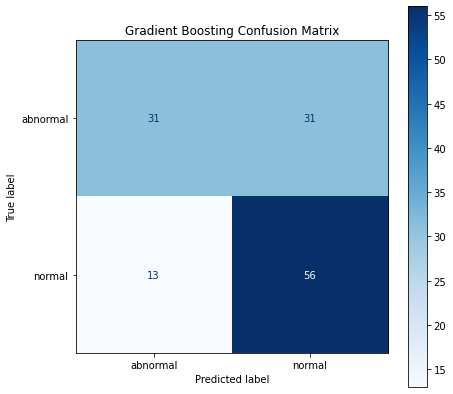

In [126]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_gb, X_test_mel, y_test,
                             display_labels = condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title("Gradient Boosting Confusion Matrix")
plt.show()

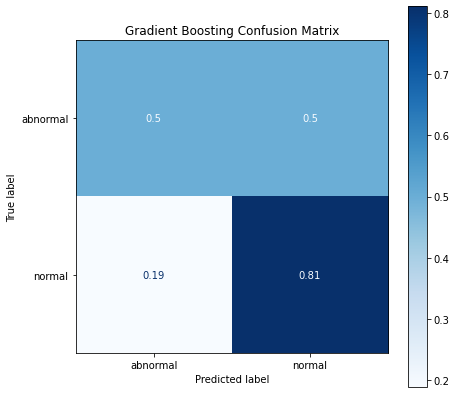

In [127]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_gb, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='true',
                             ax=ax)
disp.ax_.set_title("Gradient Boosting Confusion Matrix")
plt.show()

In [128]:
print(classification_report(y_test, my_gb.predict(X_test_mel)))

              precision    recall  f1-score   support

           0       0.70      0.50      0.58        62
           1       0.64      0.81      0.72        69

    accuracy                           0.66       131
   macro avg       0.67      0.66      0.65       131
weighted avg       0.67      0.66      0.65       131



In [129]:
y_proba = my_gb.predict_proba(X_test_mel)

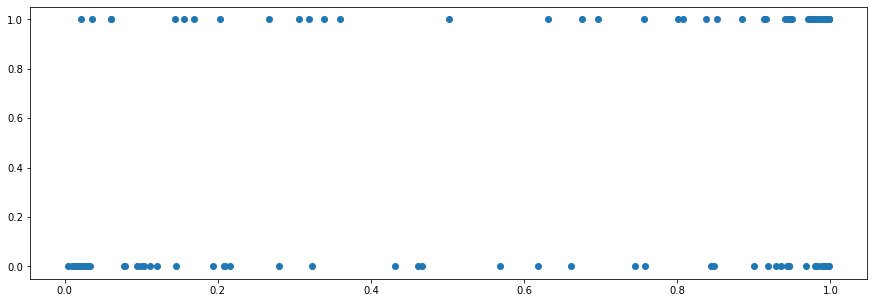

In [130]:
plt.figure(figsize=(15, 5))
plt.scatter(y_proba[:, 1], 
            y_test)
plt.show();